importing all the required libraries that i may require

In [32]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV

Create a dictionary to convert the integer value predicted at the end to name of specific feild

In [33]:
#creating a dictionary
field = {1:"empty",
              2:"love",
              3:"enthusiasm",
              4:"happiness",
              5:"boredom", 
              6:"relief",
              7:"hate",
              8:"anger",
              9:"sadness",
              10:"suprise", 
              11:"neutral",
              12:"fun",
              13:"worry" 
    }

Taking input from the user and converrting it to required dataframe.Also loading the train dataset

In [34]:
s="Hello I am having a good day"
d = {'sentiment':0, 'content':s}
inp = pd.DataFrame(d,index=[0])
    
#loading the train dataset
dataset1 = pd.read_csv('emotions.csv',encoding='latin-1')
dataset2 = dataset1.iloc[0:30000,[0,1]]
dataset2['content'].fillna(value="good", inplace=True)
dataset = dataset2.append(inp,ignore_index=True)

In [35]:
dataset.head(10)

,sentiment,content
0,1,@tiffanylue i know i was listenin to bad habi...
1,9,Layin n bed with a headache ughhhh...waitin o...
2,9,Funeral ceremony...gloomy friday...
3,3,wants to hang out with friends SOON!
4,11,@dannycastillo We want to trade with someone w...
5,13,Re-pinging @ghostridah14: why didn't you go to...
6,9,"I should be sleep, but im not! thinking about ..."
7,13,Hmmm. http://www.djhero.com/ is down
8,9,@charviray Charlene my love. I miss you
9,9,@kelcouch I'm sorry at least it's Friday?


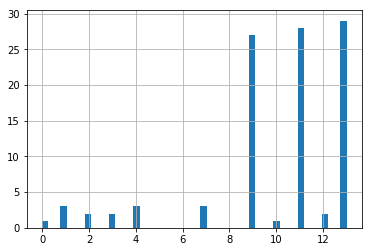

In [36]:
dataset['sentiment'].hist(bins=50)

Cleaning the text.Extracting only the important words that may affect the behaviour.Using Natural Language Processing to extract words.

In [37]:
# Cleaning the texts
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
corpus = []
for i in range(0,30001):
    review = re.sub('[^a-zA-Z]', ' ', dataset['content'][i])
    review = review.lower()
    review = review.split()
    ps = PorterStemmer()
    review = [ps.stem(word) for word in review if not word in set(stopwords.words('english'))]
    review = ' '.join(review)
    corpus.append(review)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sankalp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [38]:
print("data filtered")

data filtered


In [39]:
print(corpus[5])

ping ghostridah go prom bc bf like friend


Creating a bag of words from the corpus generated array

In [40]:
# Creating the Bag of Words model
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_features = 3000)
X = cv.fit_transform(corpus).toarray()
y = dataset.iloc[:, 0].values

In [41]:
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

Spliting the dataset into train and test from better results.

In [42]:
print("Split begin")
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

Split begin


Starting the model training using StartifiedKFold technique and Stacking

In [43]:
#stacking
def Stacking(model,train,y,test,n_fold):
    folds=StratifiedKFold(n_splits=n_fold,random_state=1)
    test_pred=np.empty((test.shape[0],1),float)
    train_pred=np.empty((0,1),float)
    for train_indices,val_indices in folds.split(train,y):
        x_train,x_val=train[train_indices],train[val_indices]
        y_train,y_val=y[train_indices],y[val_indices]
            
        model.fit(X=x_train,y=y_train)
        train_pred=np.append(train_pred,model.predict(x_val))
        test_pred=np.append(test_pred,model.predict(test))
    return test_pred.reshape(-1,1),train_pred

Creating a random forest classifier and applying Hyperparameter tuning to obtain the correct values of parameter

In [44]:
#Random forest
print("Random forest")
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint
# Creating the hyperparameter grid  
param_dist = {"n_estimators": [50,100,150], 
                  "max_features": randint(1, 9), 
                  "min_samples_leaf": randint(1, 9), 
                  "criterion": ["gini", "entropy"]} 
classifier = RandomForestClassifier()
random_cv = RandomizedSearchCV(classifier, param_dist, cv = 5)
test_pred2 ,train_pred2=Stacking(model=random_cv,n_fold=5,train=X_train,test=X_test,y=y_train)

Random forest


C:\Users\sankalp\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\sankalp\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\sankalp\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\sankalp\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 m

In [45]:
# Print the tuned parameters and score 
print("Tuned Random Forest Parameters: {}".format(random_cv.best_params_)) 
print("Best score is {}".format(random_cv.best_score_)) 

Tuned Random Forest Parameters: {'criterion': 'gini', 'max_features': 3, 'min_samples_leaf': 4, 'n_estimators': 50}
Best score is 0.29850746268656714


Creating a Decision tree classifier and applying hyper parameter tuning

In [46]:
 #Decision tree
print("Decision Tree Classifier")
from scipy.stats import randint
# Creating the hyperparameter grid  
param_dist = {"max_depth": [3, None], 
                  "max_features": randint(1, 9), 
                  "min_samples_leaf": randint(1, 9), 
                  "criterion": ["gini", "entropy"]} 
model1 = DecisionTreeClassifier(random_state=1)
model1_cv = RandomizedSearchCV(model1, param_dist, cv = 5)
test_pred3 ,train_pred3=Stacking(model=model1_cv,n_fold=5, train=X_train,test=X_test,y=y_train)
    
    
# Print the tuned parameters and score 
print("Tuned Decision Tree Parameters: {}".format(model1_cv.best_params_)) 
print("Best score is {}".format(model1_cv.best_score_)) 

Decision Tree Classifier


C:\Users\sankalp\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\sankalp\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\sankalp\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\sankalp\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 m

Tuned Decision Tree Parameters: {'criterion': 'gini', 'max_depth': 3, 'max_features': 7, 'min_samples_leaf': 2}
Best score is 0.31343283582089554


C:\Users\sankalp\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\sankalp\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\sankalp\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Creating a KNearest Classifier and applying the same.

In [47]:
print("K Neighbours Classifier")
from scipy.stats import randint
# Creating the hyperparameter grid  
param_dist = {"n_neighbors": [5, 10], 
                  "algorithm": ["auto", "ball_tree", "kd_tree", "brute"]} 
model2 = KNeighborsClassifier()
model2_cv = RandomizedSearchCV(model2, param_dist, cv = 5)
test_pred4 ,train_pred4=Stacking(model=model2_cv,n_fold=5, train=X_train,test=X_test,y=y_train)
    
    
# Print the tuned parameters and score 
print("Tuned KNN Parameters: {}".format(model2_cv.best_params_)) 
print("Best score is {}".format(model2_cv.best_score_)) 

K Neighbours Classifier


C:\Users\sankalp\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\sankalp\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:271: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
C:\Users\sankalp\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\sankalp\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to

Tuned KNN Parameters: {'n_neighbors': 5, 'algorithm': 'brute'}
Best score is 0.29850746268656714


C:\Users\sankalp\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Converting the results obtained from the above models to data frame

In [48]:
#converting to dataframe
    
train_pred2=pd.DataFrame(train_pred2)
test_pred2=pd.DataFrame(test_pred2)
    
train_pred3=pd.DataFrame(train_pred3)
test_pred3=pd.DataFrame(test_pred3)
    
train_pred4=pd.DataFrame(train_pred4)
test_pred4=pd.DataFrame(test_pred4)

Applying Second Level Model to combine the result of all the above models

In [49]:
print('Logistic Regression')
df = pd.concat([ train_pred2,train_pred3,train_pred4], axis=1)
df_test = pd.concat([ test_pred2,test_pred3,test_pred4], axis=1)
df_test = df_test.fillna(0)
model = LogisticRegression(random_state=1)
model.fit(df,y_train)
y_pred = model.predict(df_test)

Logistic Regression


C:\Users\sankalp\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\sankalp\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [50]:
arr = y_pred[0:len(y_test)]

Analysis the results and the accuracy obtained

In [51]:
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, arr)
print("confusion matrix is:")
print(cm)

confusion matrix is:
[[0 0 0 0 2]
 [0 0 0 0 2]
 [0 0 0 0 6]
 [0 0 0 0 7]
 [0 0 0 0 4]]


In [52]:
import seaborn as sn

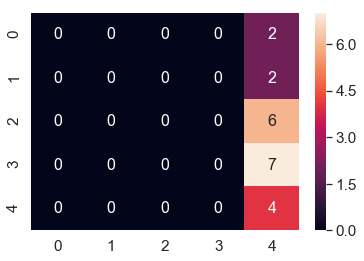

In [53]:
df_cm = pd.DataFrame(cm, range(5),
                  range(5))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 16})# font size

The final output of the result

In [54]:
output = y_pred[-1]
print("output is:")
print(field[output])

output is:
worry
